In [1286]:
import torch
import random
import numpy as np
import json
import torch
import matplotlib.pyplot as plt
import numpy



random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


In [1287]:
with open('level_data.txt', 'r') as filehandle:
    level_data = json.load(filehandle)
with open('weather_data.txt', 'r') as filehandle:
    weather_data = json.load(filehandle)

dataset_x = []
dataset_y = []
for year in range(0, 19):
    for month in [3, 4]:
        lst = []
        if month > 0:
            for w in weather_data[year][month-1][len(weather_data[year][month-1])-90+len(weather_data[year][month]):] + weather_data[year][month]:
                w['tempreture'] += 50
                lst.append(list(w.values()))
        else:
            if year > 0:
                for w in weather_data[year-1][11][len(weather_data[year-1][11]) - 90+len(weather_data[year][month]):] + weather_data[year][month]:
                    w['tempreture'] += 50
                    lst.append(list(w.values()))
        if lst:
            if len(lst) == 90:
                dataset_x.append(lst)
                dataset_y.append(level_data[year][month])

In [1288]:
dataset_x = torch.Tensor(dataset_x)
dataset_y = torch.Tensor(dataset_y)
print(len(dataset_x))


38


In [1289]:
X_train = dataset_x[:35]
y_train = dataset_y[:35]
X_test = dataset_x[35:]
y_test = dataset_y[35:]


In [1290]:


X_train.dtype, y_train.dtype



(torch.float32, torch.float32)

In [1291]:


X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()
f1 = torch.nn.ReLU()
f2 = torch.nn.ReLU()
y_test = f1(y_test)
y_train = f2(y_train)



In [1292]:

X_train.shape, X_test.shape


(torch.Size([35, 90, 6]), torch.Size([3, 90, 6]))

In [1293]:


X_train = X_train.reshape([-1,90 * 6])
X_test = X_test.reshape([-1, 90 * 6])
X_train.data



tensor([[ 46., 773.,   4.,  ...,   0.,   2.,   5.],
        [100., 754.,   1.,  ...,   0.,   5.,   4.],
        [ 40., 759.,   1.,  ...,   0.,   6.,   4.],
        ...,
        [ 55., 738.,   4.,  ...,   0.,   6.,   4.],
        [114., 756.,   3.,  ...,   0.,   8.,   3.],
        [ 50., 770.,   1.,  ...,   0.,   7.,   1.]])

In [1294]:
class RiverNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(RiverNet, self).__init__()
        self.fc1 = torch.nn.Linear(90 * 6, n_hidden_neurons)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 512)
        self.ac2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(512, 256)
        self.ac3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(256, 128)
        self.ac4 = torch.nn.ReLU()
        self.fc5 = torch.nn.Linear(128, 64)
        self.ac5 = torch.nn.ReLU()
        self.fc6 = torch.nn.Linear(64, 32)
        self.ac6 = torch.nn.ReLU()
        self.fc7 = torch.nn.Linear(32, 1)
        self.ac7 = torch.nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.fc4(x)
        x = self.ac4(x)
        x = self.fc5(x)
        x = self.ac5(x)
        x = self.fc6(x)
        x = self.ac6(x)
        x = self.fc7(x)
        x = self.ac7(x)
        return x

river_net = RiverNet(1000)


In [1295]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
river_net = river_net.to(device)

In [1296]:


loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(river_net.parameters(), lr=1.0e-3)


In [1297]:
batch_size = 1

# test_accuracy_history = []
# test_loss_history = []

# X_test = X_test.to(device)
# y_test = y_test.to(device)
x = torch.Tensor()
y = torch.Tensor()

for epoch in range(350):
    order = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]


        X_batch = X_train[batch_indexes] #.to(device)
        y_batch = y_train[batch_indexes] #.to(device)
        preds = river_net.forward(X_batch)

        # print("------------------")
        # print(preds)
        # print(y_batch)

        loss_value = loss(preds.float(), y_batch.float())
        loss_value.backward()

        optimizer.step()

    test_preds = river_net.forward(X_test)
#     test_loss_history.append(loss(test_preds, y_test))
    a = []
    for i in range(len(y_test)):
        a.append((test_preds[i] - y_test[i])**2)

    a = torch.Tensor(a)
    accuracy = a.float().mean()
#     test_accuracy_history.append(accuracy)
    print(accuracy, epoch)

f:\ilya\pycharmprojects\river\venv\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(89951.8203) 0
tensor(62781.5156) 1
tensor(36707.0195) 2
tensor(39012.5430) 3
tensor(47239.3633) 4
tensor(115562.0938) 5
tensor(36797.8164) 6
tensor(36125.7539) 7
tensor(50173.8164) 8
tensor(40017.1250) 9
tensor(47421.4531) 10
tensor(55844.4180) 11
tensor(84815.2422) 12
tensor(50363.9062) 13
tensor(41502.6992) 14
tensor(35197.6133) 15
tensor(34655.4492) 16
tensor(36105.3750) 17
tensor(37022.4531) 18
tensor(42592.6328) 19
tensor(35061.1523) 20
tensor(34832.4727) 21
tensor(34635.2656) 22
tensor(33834.6914) 23
tensor(34121.8633) 24
tensor(70120.6094) 25
tensor(37644.1445) 26
tensor(33427.1562) 27
tensor(44692.5195) 28
tensor(37066.0156) 29
tensor(38989.3242) 30
tensor(33150.5352) 31
tensor(36170.1094) 32
tensor(38233.9336) 33
tensor(34547.2148) 34
tensor(39476.7812) 35
tensor(32648.3281) 36
tensor(34575.2930) 37
tensor(44110.5312) 38
tensor(42785.4727) 39
tensor(37405.5938) 40
tensor(53337.1992) 41
tensor(31527.0527) 42
tensor(34285.2461) 43
tensor(35176.0156) 44
tensor(31046.0527) 

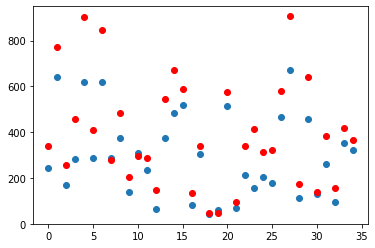

In [1298]:
for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]


        X_batch = X_train[batch_indexes] #.to(device)
        y_batch = y_train[batch_indexes] #.to(device)
        preds = river_net.forward(X_batch)
        x = torch.cat((x, y_batch),dim=0)
        y = torch.cat((y, preds),dim=0)
k = list([i for i in range(len(y))])
plt.plot(numpy.array(k), y.detach().numpy(), 'o', label='Groud truth')
plt.plot(numpy.array(k), x.detach().numpy(), 'o', c='r', label='Prediction');
